# STRATEGY ADAPTIVE PROFIT

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt


def is_time_between(start_time, end_time, check_time):
    if start_time < end_time:
        return start_time <= check_time <= end_time
    else:  # crosses midnight
        return check_time >= start_time or check_time <= end_time

dataset_name = "GBP_USD_H1"
# Read the ohlcv data
oanda_path = "/projects/genomic-ml/da2343/ml_project_2/data/gen_oanda_data"
# oanda_path = "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data"
df = pd.read_csv(f'{oanda_path}/{dataset_name}_processed_data.csv')
df = df.rename(columns={"time": "Time"})
df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]
df["Time"] = pd.to_datetime(df["Time"])
df['EMA_100'] = ta.EMA(df['Close'], timeperiod=100)
# drop na values
df = df.dropna()
# filter when time is only in 2016
# df = df[df["Time"] >= "2016-01-01 00:00:00"]

# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []
atr_delta = 1.5
start_time = 13
end_time = 17

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_one = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    condition_two = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    if position == 0:
        if condition_one:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_two:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            stop_loss = max(stop_loss,  row['Close'] - atr_delta*row['ATR'])
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        else:
            stop_loss = min(stop_loss, row['Close'] + atr_delta*row['ATR'])

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

,Action,Time,Price,PnL,PnL_label
0,Sell,2005-01-07 19:00:00+00:00,1.872669,-0.716345,0
1,Buy,2005-01-13 08:00:00+00:00,1.888522,0.510915,1
2,Buy,2005-01-21 01:00:00+00:00,1.867882,-0.629903,0
3,Buy,2005-01-24 02:00:00+00:00,1.874704,0.160255,1
4,Buy,2005-01-28 04:00:00+00:00,1.886042,-0.141229,0
...,...,...,...,...,...
1035,Buy,2023-12-04 00:00:00+00:00,1.268134,0.033617,1
1036,Sell,2023-12-06 05:00:00+00:00,1.261288,-0.002669,0
1037,Sell,2023-12-07 07:00:00+00:00,1.256740,0.554409,1
1038,Sell,2023-12-11 19:00:00+00:00,1.256500,-1.000000,0


<Axes: >

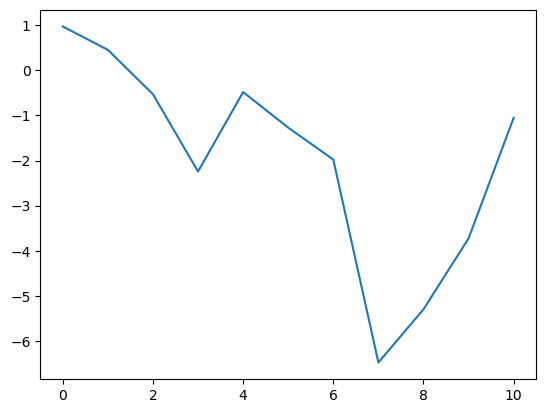

In [10]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2016].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()

# using the label column find the cumulative sum
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
#plot first 100 trades
sub_trades_df["cumulative_sum"].plot()
# sub_trades_df

In [ ]:
# EUR_USD_H1 : off-years = 2014, 2016, 2021
# EUR_JPY_H1 : off-years = 2016
# GBP_JPY_H1 : off-years = 2023
# USD_MXN_H1 : off-years = 2018, 2019, 2022
# NZD_JPY_H1 : off-years = 2014, 2015, 2019

# AUD_HKD_H1 : off-years = 2015, 2018, 2019, 2021
# EUR_GBP_H1 : off-years = 2018, 2021, 2022, 2023

# ZAR_JPY_H1 : off-years = 2014, 2015, 2017, 2019
# USD_NOK_H1 : off-years = 2014, 2015
# USD_CHF_H1 : off-years = 2014
# TRY_JPY_H1 : off-years = 2014, 2019, 2021, 2022, 2023
# AUD_USD_H1 : off-years = 2015,2016,2018, 2019, 2022

In [28]:
trades_df["PnL_label"].mean()

0.3640661938534279

# STRATEGY FIXED PROFIT

In [23]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []
atr_delta = 1.5
start_time = 13
end_time = 17

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_buy = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    condition_sell = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    if position == 0:
        if condition_buy:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            take_profit = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            pass
            # stop_loss = max(stop_loss,  row['Close'] - atr_delta*row['ATR'])
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]    
        else:
            pass
            # stop_loss = min(stop_loss, row['Close'] + atr_delta*row['ATR'])

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df


,Action,Time,Price,PnL,PnL_label
0,Sell,2005-01-10 03:00:00+00:00,1.874518,-1.0,0
1,Buy,2005-01-12 15:00:00+00:00,1.891032,1.0,1
2,Buy,2005-01-21 09:00:00+00:00,1.865932,-1.0,0
3,Buy,2005-01-21 17:00:00+00:00,1.879440,1.0,1
4,Buy,2005-01-27 22:00:00+00:00,1.891357,1.0,1
...,...,...,...,...,...
1022,Buy,2023-12-01 18:00:00+00:00,1.271422,1.0,1
1023,Sell,2023-12-05 16:00:00+00:00,1.258270,1.0,1
1024,Sell,2023-12-06 20:00:00+00:00,1.255647,1.0,1
1025,Sell,2023-12-11 19:00:00+00:00,1.256500,-1.0,0


<Axes: >

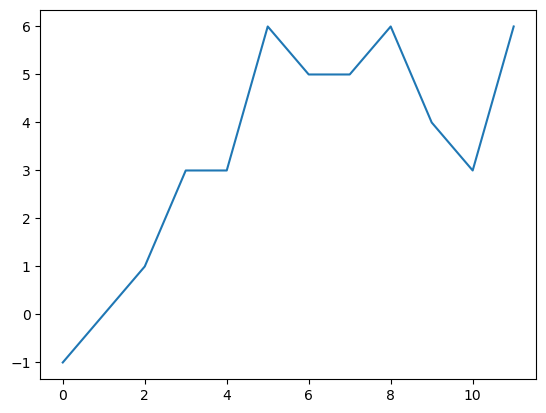

In [37]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2015].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()

# using the label column find the cumulative sum
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
#plot first 100 trades
sub_trades_df["cumulative_sum"].plot()
# sub_trades_df

In [ ]:
# AUD_HKD_H1 : off-years = 2015, 2018
# EUR_GBP_H1: 2018, 2019, 2021
